In [1]:
import json
from tqdm import tqdm

from judge_reddit import build_thread_qbaf
from gradual_semantics import basic_tau, qem_semantics, df_quad_semantics, reb_semantics, quad_semantics
from qbafs import QBAF

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

import seaborn as sns
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties
import matplotlib

KeyboardInterrupt: 

## Set Up

In [ ]:
# Load data

reddit_posts = pd.read_csv('../reddit_data/post_dataset.tsv', encoding='utf-16', sep='\t')
print(reddit_posts.columns)
verdict_labels = reddit_posts['verdict'].apply(lambda x: 1 if x == 'NTA' else -1)
print(verdict_labels.value_counts())

Index(['Unnamed: 0', 'title', 'verdict', 'thread file', 'total comments'], dtype='object')
verdict
-1    433
 1    390
Name: count, dtype: int64


In [ ]:
# Build QBAFs
thread_jsons = reddit_posts['thread file'].apply(lambda fn: json.load(open(f'../reddit_data/{fn}')))
thread_qbafs = thread_jsons.apply(lambda j: build_thread_qbaf(j, tau_func = lambda a: basic_tau(a, x=0.5), nr=True))

In [ ]:
# Set aside 20% of the data for testing
train_data, test_data, train_labels, test_labels, train_qbafs, test_qbafs, train_jsons, test_jsons = train_test_split(reddit_posts, verdict_labels, thread_qbafs, thread_jsons, test_size=0.2, random_state=52)

# Create 5-Fold Cross Validation from the training data
SEED = 52
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=SEED)
folds = kf.split(train_data)

fold_data = [{} for i in range(K)]
for i, (train_index, test_index) in enumerate(folds):
    fold_data[i]['train'] = train_data.iloc[train_index]
    fold_data[i]['test'] = train_data.iloc[test_index]
    fold_data[i]['train_labels'] = train_labels.iloc[train_index]
    fold_data[i]['test_labels'] = train_labels.iloc[test_index]
    fold_data[i]['train_qbafs'] = train_qbafs.iloc[train_index]
    fold_data[i]['test_qbafs'] = train_qbafs.iloc[test_index]
    fold_data[i]['train_jsons'] = train_jsons.iloc[train_index]
    fold_data[i]['test_jsons'] = train_jsons.iloc[test_index]
fold_results = [{} for i in range(K)]

best_configs = {}

## Helper Functions

### Plotting Functions

In [ ]:
PLOTS_DIR = 'plots/'

In [ ]:
def line_graph(x, y, xlabel, ylabel, title, ax, labels=None, average=False, colour=None):
    if labels is not None:
        if average:
            means = np.mean(y, axis=0)
            stds = np.std(y, axis=0)
            ax.plot(x, means, color=colour, label='Mean')
            ax.fill_between(x, means-stds, means+stds, alpha=0.2, color=colour, label='Standard Deviation')
        else:
            for i, label in enumerate(labels):
                sns.lineplot(x=x, y=y[i], label=label, ax=ax)
        ax.legend()
    else:
        sns.lineplot(x=x, y=y, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [ ]:
def classification_metrics(true, predicted):
    return {
        'accuracy': accuracy_score(true, predicted),
        'precision': precision_score(true, predicted),
        'recall': recall_score(true, predicted),
        'f1': f1_score(true, predicted),
        'mcc': matthews_corrcoef(true, predicted),
        'roc_auc': roc_auc_score(true, predicted),
    }

def bar_chart(data, title, ax):
    colours = matplotlib.colormaps['tab10'].colors[:len(data)]
    sns.barplot(x=list(data.keys()), y=list(data.values()), ax=ax, palette=colours, hue=list(data.keys()), legend=False)
    ax.set_title(title)


def metrics_chart(true, predicted, title = 'Classifier Performance', ax=None):
    metrics = {
        'accuracy': accuracy_score(true, predicted),
        'precision': precision_score(true, predicted),
        'recall': recall_score(true, predicted),
        'f1': f1_score(true, predicted),
        'mcc': matthews_corrcoef(true, predicted),
        'roc_auc': roc_auc_score(true, predicted),
    }

    colours = matplotlib.colormaps['tab10'].colors[:len(metrics)]
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette=colours, hue=list(metrics.keys()), ax=ax, legend=False)
    ax.set_title(title)

    # plt.tight_layout()
    # plt.show()

In [ ]:
def display_confusion_matrix(true, predicted, neg_class='0', pos_class='1', title='Confusion Matrix', ax=None, colour='Blues'):
    cm = confusion_matrix(true, predicted)
    fig = plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=colour, xticklabels=[neg_class, pos_class], yticklabels=[neg_class, pos_class], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    # plt.title(title)
    # plt.show()

In [ ]:
# Boxplot of scores for each verdict
def boxplot_scores(true, predicted, ax, title='Boxplot of Scores'):
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(
        x=true, y=predicted, palette='Set2', hue=true, showmeans=True, ax=ax,
        meanprops={'marker':'o', 'markerfacecolor':'black', 'markeredgecolor':'black'},
        flierprops={'marker':'x', 'markerfacecolor':'red', 'markeredgecolor':'red'},
    )
    # add horizontal line for threshold
    ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1.0)
    ax.set_title(title)
    # plt.show()

In [ ]:
def heat_graph(x, y, z, xlabel, ylabel, zlabel, title, ax):
    sns.heatmap(z, ax=ax, xticklabels=x, yticklabels=y, cmap='viridis', fmt='.2f')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [ ]:
def surface_graph(x, y, z, xlabel, ylabel, zlabel, title, ax, itrpol=False, avg=False):
    if itrpol:
        n, m = z.shape
        xnew = np.linspace(x[0, 0], x[-1, -1], n*10)
        ynew = np.linspace(y[0, 0], y[-1, -1], m*10)
        xnew, ynew = np.meshgrid(xnew, ynew)
        tck = interpolate.bisplrep(x, y, z, s=0)
        znew = interpolate.bisplev(xnew[:, 0], ynew[0, :], tck)
        print(interpolate.bisplev(xi, yi, tck))
        ax.plot_surface(xnew, ynew, znew, cmap='viridis')
    else:
        if avg:
            means = np.mean(z, axis=0)
            stds = np.std(z, axis=0)
            ax.plot_surface(x, y, means, cmap='viridis')
            # ax.plot_surface(x, y, means-stds, cmap='viridis')
            # ax.plot_surface(x, y, means+stds, cmap='viridis')
        else:
            ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)

### Experiment Functions

In [ ]:
# Helper to gather results from QBAF classifiers with different configurations

def run_qbaf_experiment(params, config_func, qbafs=thread_qbafs, labels=verdict_labels, t_jsons=thread_jsons):
    eval_scores = {}
    preds = {}

    progress_bar = tqdm(total=len(params), initial=0)

    for p in params:
        for qbaf, t_json in zip(qbafs, t_jsons):
            config_func(qbaf, p, t_json=t_json)
        pred_verdicts = qbafs.apply(lambda qbaf: qbaf.get_stance(return_score=True))
        pred_verdicts = pd.DataFrame(pred_verdicts.tolist(), index=qbafs.index, columns=['stance', 'score'])
        preds[p] = pred_verdicts
        # Find the index of the posts with 0 stances
        zero_stance = pred_verdicts[pred_verdicts['stance'] == 0].index
        if len(zero_stance) > 0:
            print(f'Param {p} - Zero Stance: {zero_stance}')
        # Remove the posts with 0 stances
        pred_verdicts = pred_verdicts.drop(zero_stance)
        binary_labels = labels.drop(zero_stance)
        f1 = f1_score(binary_labels, pred_verdicts["stance"])
        roc_auc = roc_auc_score(binary_labels, pred_verdicts["stance"])
        score = {"f1": f1, "roc_auc": roc_auc}
        eval_scores[p] = score
        progress_bar.update(1)
    progress_bar.close()

    return eval_scores, preds

In [ ]:
def max_score_config(d):
    return max(d, key=lambda k: d[k]['f1'])


def find_misclassified(true, predicted, data=reddit_posts):
    return data[true != predicted]


def float_str(f, d=2):
    rf = round(f, d)
    return f"{rf}"

In [ ]:
def run_cross_validation(classifer_type, params, config_func):
    for i in range(K):
        print(f"Fold {i+1}")
        train_qbafs = fold_data[i]['train_qbafs']
        train_verdict_labels = fold_data[i]['train_labels']
        train_jsons = fold_data[i]['train_jsons']

        # Test stance prediction sensitivity to parameter changes
        eval_scores, preds = run_qbaf_experiment(
            params=params, config_func=config_func, qbafs=train_qbafs, labels=train_verdict_labels, t_jsons=train_jsons
        )
        best_config = max_score_config(eval_scores)
        print(f"Best config: {best_config}, with ROC-AUC = {eval_scores[best_config]['roc_auc']} and F1 = {eval_scores[best_config]['f1']}")

        # Record predictions and scores
        fold_results[i][classifer_type] = {'scores': eval_scores, 'preds': preds}

## Fixed Tau QBAF Classifier

In [ ]:
alphas = np.linspace(0.01, 0.5, 100)

### DF-Quad Semantics

In [ ]:
def update_fixed_df(qbaf, alpha, t_json=None):
    qbaf.update_tau(lambda a: basic_tau(a, x=alpha))
    qbaf.update_semantics(df_quad_semantics)

In [ ]:
run_cross_validation('fixed df-quad', alphas, update_fixed_df)

Fold 1


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


Best config: 0.23767676767676768, with ROC-AUC = 0.8305378831694622 and F1 = 0.8360957642725598
Fold 2


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Best config: 0.22282828282828282, with ROC-AUC = 0.8243467259957248 and F1 = 0.8143712574850299
Fold 3


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Best config: 0.23767676767676768, with ROC-AUC = 0.8221718404836647 and F1 = 0.8155339805825242
Fold 4


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


Best config: 0.22777777777777777, with ROC-AUC = 0.8296211550715402 and F1 = 0.821917808219178
Fold 5


100%|██████████| 100/100 [00:32<00:00,  3.09it/s]

Best config: 0.26242424242424245, with ROC-AUC = 0.8143869288606131 and F1 = 0.8092485549132948


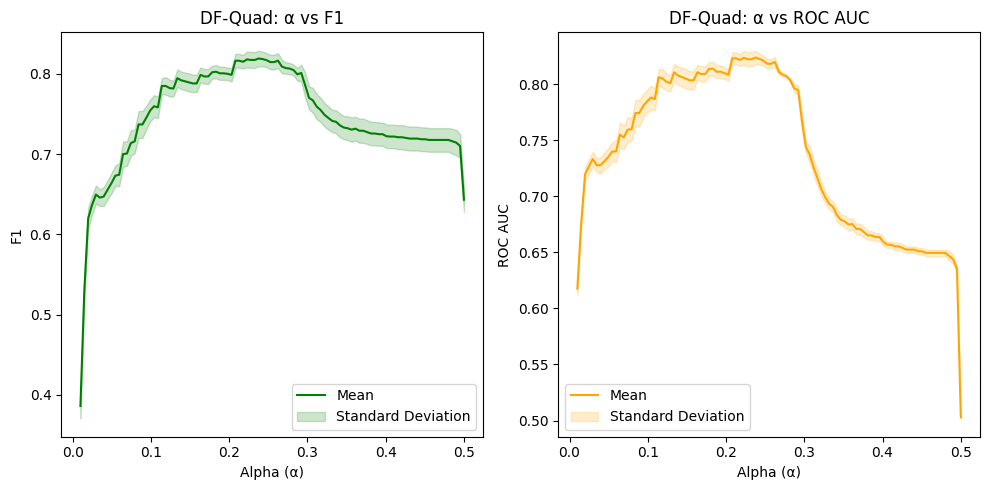

In [ ]:
# Plot alphas against F1 and ROC AUC
labels = [f"Fold {i+1}" for i in range(K)]

f1s, roc_aucs = [], []

for i in range(K):
    f1s.append([s["f1"] for s in fold_results[i]['fixed df-quad']['scores'].values()])
    roc_aucs.append([s["roc_auc"] for s in fold_results[i]['fixed df-quad']['scores'].values()])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
line_graph(alphas, f1s, "Alpha (\u03b1)", "F1", "DF-Quad: \u03b1 vs F1", axes[0], labels=labels, average=True, colour='green')
line_graph(alphas, roc_aucs, "Alpha (\u03b1)", "ROC AUC", "DF-Quad: \u03b1 vs ROC AUC", axes[1], labels=labels, average=True, colour='orange')
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}df_quad_alpha_sensitivity.png")

In [ ]:
# Record fixed tau with best average F1
mean_f1s = np.mean(f1s, axis=0)
best_alpha = alphas[np.argmax(mean_f1s)]
best_configs['fixed df-quad'] = best_alpha

### QEM Semantics

In [ ]:
def update_fixed_qem(qbaf, alpha, t_json=None):
    qbaf.update_tau(lambda a: basic_tau(a, x=alpha))
    qbaf.update_semantics(qem_semantics)

In [ ]:
run_cross_validation('fixed qem', alphas, update_fixed_qem)

Fold 1


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Best config: 0.41585858585858587, with ROC-AUC = 0.8217611336032388 and F1 = 0.8442211055276382
Fold 2


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Best config: 0.41585858585858587, with ROC-AUC = 0.8121828149311463 and F1 = 0.8149466192170819
Fold 3


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Best config: 0.41585858585858587, with ROC-AUC = 0.8211545169166375 and F1 = 0.8241563055062167
Fold 4


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Best config: 0.41585858585858587, with ROC-AUC = 0.8146324509065631 and F1 = 0.818342151675485
Fold 5


100%|██████████| 100/100 [00:31<00:00,  3.17it/s]

Best config: 0.41585858585858587, with ROC-AUC = 0.8086827646038173 and F1 = 0.8148148148148148


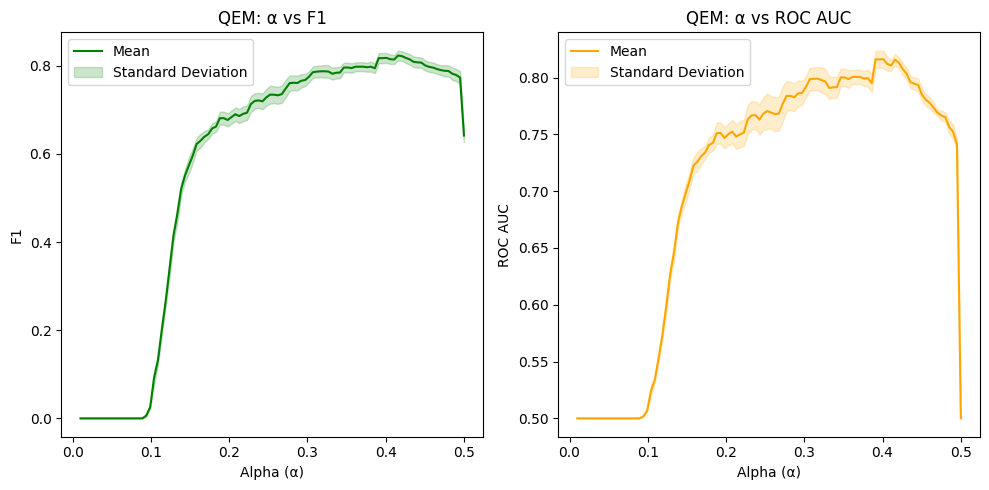

In [ ]:
labels = [f"Fold {i+1}" for i in range(K)]

f1s, roc_aucs = [], []

for i in range(K):
    f1s.append([s["f1"] for s in fold_results[i]['fixed qem']['scores'].values()])
    roc_aucs.append([s["roc_auc"] for s in fold_results[i]['fixed qem']['scores'].values()])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
line_graph(alphas, f1s, "Alpha (\u03b1)", "F1", "QEM: \u03b1 vs F1", axes[0], labels=labels, average=True, colour='green')
line_graph(alphas, roc_aucs, "Alpha (\u03b1)", "ROC AUC", "QEM: \u03b1 vs ROC AUC", axes[1], labels=labels, average=True, colour='orange')
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}qem_alpha_sensitivity.png")

In [ ]:
mean_f1s = np.mean(f1s, axis=0)
best_alpha = alphas[np.argmax(mean_f1s)]
best_configs['fixed qem'] = best_alpha

### QuAD Semantics

In [ ]:
def update_fixed_quad(qbaf, alpha, t_json=None):
    qbaf.update_tau(lambda a: basic_tau(a, x=alpha))
    qbaf.update_semantics(quad_semantics)

In [ ]:
run_cross_validation('fixed quad', alphas, update_fixed_quad)

Fold 1


100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


Best config: 0.16343434343434343, with ROC-AUC = 0.7669028340080972 and F1 = 0.791095890410959
Fold 2


100%|██████████| 100/100 [00:32<00:00,  3.06it/s]


Best config: 0.16343434343434343, with ROC-AUC = 0.7468772266573601 and F1 = 0.7535714285714286
Fold 3


100%|██████████| 100/100 [00:26<00:00,  3.77it/s]


Best config: 0.16343434343434343, with ROC-AUC = 0.7488082781071969 and F1 = 0.7575221238938054
Fold 4


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


Best config: 0.16343434343434343, with ROC-AUC = 0.7415643283322713 and F1 = 0.7495559502664298
Fold 5


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

Best config: 0.16343434343434343, with ROC-AUC = 0.7454598033545402 and F1 = 0.7553191489361702


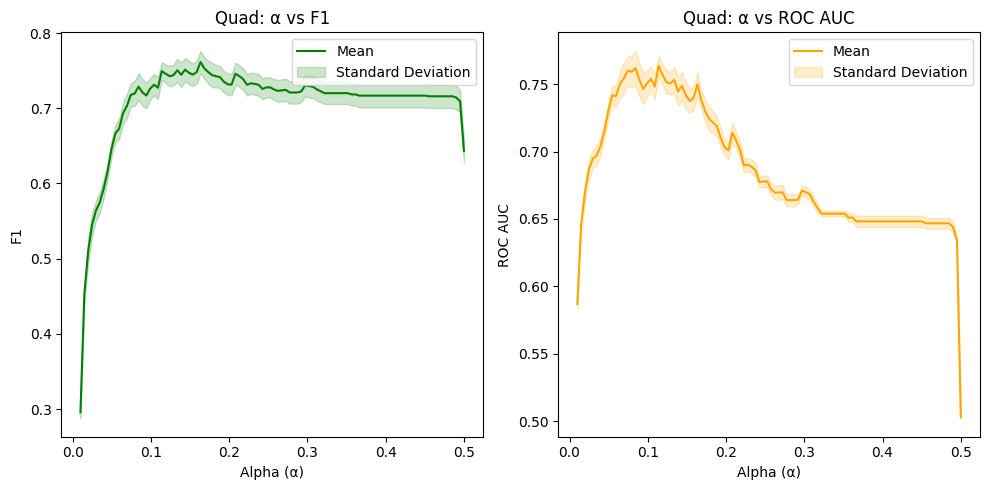

In [ ]:
labels = [f"Fold {i+1}" for i in range(K)]

f1s, roc_aucs = [], []
for i in range(K):
    f1s.append([s["f1"] for s in fold_results[i]['fixed quad']['scores'].values()])
    roc_aucs.append([s["roc_auc"] for s in fold_results[i]['fixed quad']['scores'].values()])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
line_graph(alphas, f1s, "Alpha (\u03b1)", "F1", "Quad: \u03b1 vs F1", axes[0], labels=labels, average=True, colour='green')
line_graph(alphas, roc_aucs, "Alpha (\u03b1)", "ROC AUC", "Quad: \u03b1 vs ROC AUC", axes[1], labels=labels, average=True, colour='orange')
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}quad_alpha_sensitivity.png")

In [ ]:
mean_f1s = np.mean(f1s, axis=0)
best_alpha = alphas[np.argmax(mean_f1s)]
best_configs['fixed quad'] = best_alpha

### REB Semantics

In [ ]:
def update_fixed_reb(qbaf, alpha, t_json=None):
    qbaf.update_tau(lambda a: basic_tau(a, x=alpha))
    qbaf.update_semantics(reb_semantics)

In [ ]:
run_cross_validation('fixed reb', alphas, update_fixed_reb)

Fold 1


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Best config: 0.18818181818181817, with ROC-AUC = 0.8218912666281086 and F1 = 0.8426395939086294
Fold 2


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Best config: 0.18818181818181817, with ROC-AUC = 0.8113103287818639 and F1 = 0.8129496402877698
Fold 3


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


Best config: 0.18818181818181817, with ROC-AUC = 0.8241483548424602 and F1 = 0.8258527827648114
Fold 4


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Best config: 0.18818181818181817, with ROC-AUC = 0.8099692984996814 and F1 = 0.8128342245989305
Fold 5


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]

Best config: 0.18818181818181817, with ROC-AUC = 0.8077284557547716 and F1 = 0.8121645796064401


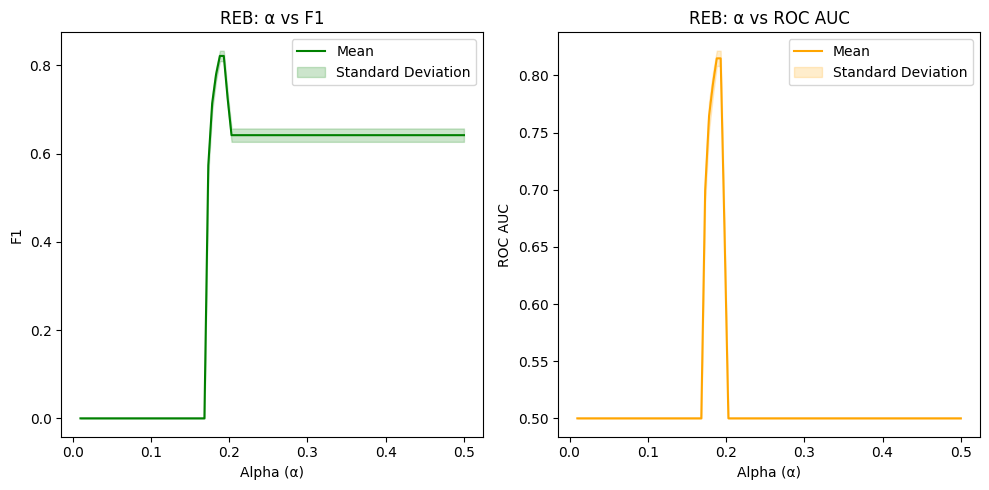

In [ ]:
labels = [f"Fold {i+1}" for i in range(K)]

f1s, roc_aucs = [], []
for i in range(K):
    f1s.append([s["f1"] for s in fold_results[i]['fixed reb']['scores'].values()])
    roc_aucs.append([s["roc_auc"] for s in fold_results[i]['fixed reb']['scores'].values()])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
line_graph(alphas, f1s, "Alpha (\u03b1)", "F1", "REB: \u03b1 vs F1", axes[0], labels=labels, average=True, colour='green')
line_graph(alphas, roc_aucs, "Alpha (\u03b1)", "ROC AUC", "REB: \u03b1 vs ROC AUC", axes[1], labels=labels, average=True, colour='orange')
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}reb_alpha_sensitivity.png")

In [ ]:
mean_f1s = np.mean(f1s, axis=0)
best_alpha = alphas[np.argmax(mean_f1s)]
best_configs['fixed reb'] = best_alpha

## Upvote Tau QBAF Classifier

In [ ]:
# Test stance prediction with tau based on upvote scores

def upvote_tau(a: tuple[int, dict], s_min = 0, s_max = 1, alpha = 0.2, beta = 0.3, normed = False, s_mean=0, s_std=1):
    if not a[1].get('score') or s_max == s_min:
        return alpha + 0.5 * beta
    else:
        score = a[1]['score']
        if normed:
            x = (score - s_mean) / s_std
            x = (x - s_min) / (s_max - s_min)
        else:
            x = (score - s_min) / (s_max - s_min)
        return alpha + beta * x

def find_scores(comment, scores):
        scores.append(comment['score'])
        for c in comment['comments']:
            find_scores(c, scores)

def get_upvote_range(thread_json):
    scores = []

    for com in thread_json['comments']:
        find_scores(com, scores)

    return np.min(scores), np.max(scores)

# Unnecessary
def get_upvote_distribution(thread_json):
    scores = []

    for com in thread_json['comments']:
        find_scores(com, scores)

    m, s = np.mean(scores), np.std(scores)
    # if standard deviation is too small, return m = 0, s = 1, s_min = 0, s_max = 1
    # so that the bias is constant (prevents division by zero)
    if s < 1e-3:
        m, s = 0, 1
        s_min, s_max = 0, 1
    else:
        normed_scores = (np.array(scores) - m) / s
        s_min, s_max = np.min(normed_scores), np.max(normed_scores)

    return m, s, s_min, s_max

In [ ]:
num_alphas, num_betas = 40, 40
# num_alphas, num_betas = 20, 20
alphas = np.linspace(0.01, 0.2, num_alphas)
betas = np.linspace(0.01, 0.8, num_betas)

ab_pairs = [(a, b) for a in alphas for b in betas]

### DF-QuAD Semantics

In [ ]:
def update_upvote_df(qbaf, ab, t_json):
    t_min, t_max = get_upvote_range(t_json)
    qbaf.update_tau(lambda n: upvote_tau(n, t_min, t_max, alpha=ab[0], beta=ab[1]))
    qbaf.update_semantics(df_quad_semantics)

In [ ]:
run_cross_validation('upvote df-quad', ab_pairs, update_upvote_df)

Fold 1


100%|██████████| 1600/1600 [14:38<00:00,  1.82it/s]


Best config: (0.01, 0.5164102564102564), with ROC-AUC = 0.8548438403701563 and F1 = 0.8647686832740213
Fold 2


100%|██████████| 1600/1600 [10:13<00:00,  2.61it/s]


Best config: (0.01, 0.49615384615384617), with ROC-AUC = 0.8481437857174018 and F1 = 0.8423076923076923
Fold 3


100%|██████████| 1600/1600 [08:38<00:00,  3.09it/s]


Best config: (0.024615384615384615, 0.5366666666666666), with ROC-AUC = 0.8338419951168469 and F1 = 0.8351254480286738
Fold 4


100%|██████████| 1600/1600 [05:41<00:00,  4.68it/s]


Best config: (0.06358974358974359, 0.2935897435897436), with ROC-AUC = 0.8508225684991021 and F1 = 0.8416833667334669
Fold 5


100%|██████████| 1600/1600 [05:28<00:00,  4.87it/s]

Best config: (0.014871794871794873, 0.49615384615384617), with ROC-AUC = 0.8292727009832273 and F1 = 0.8270676691729323


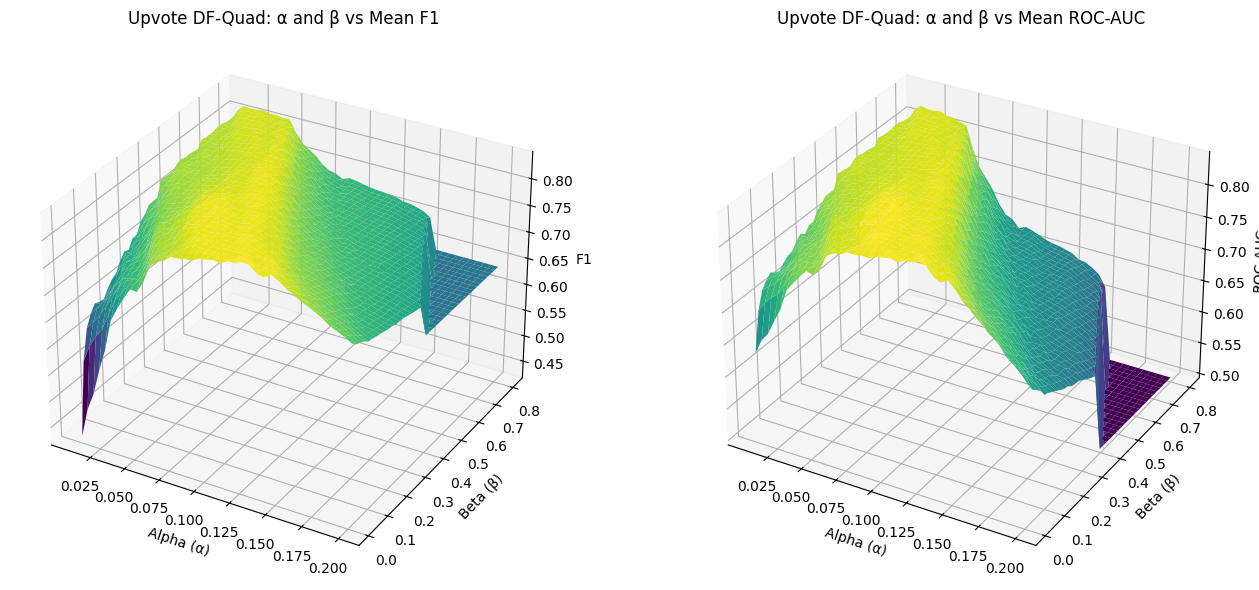

In [ ]:
f1s, roc_aucs = [], []
for i in range(K):
    f1s.append([[fold_results[i]['upvote df-quad']['scores'][(a, b)]['f1'] for b in betas] for a in alphas])
    roc_aucs.append([[fold_results[i]['upvote df-quad']['scores'][(a, b)]['roc_auc'] for b in betas] for a in alphas])

X, Y = np.meshgrid(alphas, betas)

f1s, roc_aucs = np.array(f1s), np.array(roc_aucs)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})
surface_graph(X, Y, f1s, "Alpha (\u03b1)", "Beta (\u03b2)", "F1", "Upvote DF-Quad: \u03b1 and \u03b2 vs Mean F1", axes[0], avg=True)
surface_graph(X, Y, roc_aucs, "Alpha (\u03b1)", "Beta (\u03b2)", "ROC-AUC", "Upvote DF-Quad: \u03b1 and \u03b2 vs Mean ROC-AUC", axes[1], avg=True)
fig.tight_layout()
fig.savefig(f'{PLOTS_DIR}upvote_df-quad_tuning.png')

In [ ]:
# Record best alpha and beta with best average F1
mean_f1s = np.mean(f1s, axis=0)
best_alpha, best_beta = np.unravel_index(np.argmax(mean_f1s, axis=None), mean_f1s.shape)
best_configs['upvote df-quad'] = (alphas[best_alpha], betas[best_beta])

### QEM Semantics

In [ ]:
def update_upvote_qem(qbaf, ab, t_json):
    t_min, t_max = get_upvote_range(t_json)
    qbaf.update_tau(lambda n: upvote_tau(n, t_min, t_max, alpha=ab[0], beta=ab[1]))
    qbaf.update_semantics(qem_semantics)

In [ ]:
run_cross_validation('upvote qem', ab_pairs, update_upvote_qem)

Fold 1


100%|██████████| 1600/1600 [07:21<00:00,  3.62it/s]


Best config: (0.01, 0.8), with ROC-AUC = 0.8643724696356275 and F1 = 0.8734402852049911
Fold 2


100%|██████████| 1600/1600 [06:34<00:00,  4.06it/s]


Best config: (0.04897435897435898, 0.718974358974359), with ROC-AUC = 0.855792580959444 and F1 = 0.85
Fold 3


100%|██████████| 1600/1600 [06:49<00:00,  3.90it/s]


Best config: (0.014871794871794873, 0.7797435897435898), with ROC-AUC = 0.8530258109522149 and F1 = 0.8471953578336557
Fold 4


100%|██████████| 1600/1600 [05:58<00:00,  4.46it/s]


Best config: (0.024615384615384615, 0.7797435897435898), with ROC-AUC = 0.8464345710479058 and F1 = 0.8451730418943534
Fold 5


100%|██████████| 1600/1600 [06:14<00:00,  4.27it/s]

Best config: (0.024615384615384615, 0.7797435897435898), with ROC-AUC = 0.831897050318103 and F1 = 0.8339350180505415


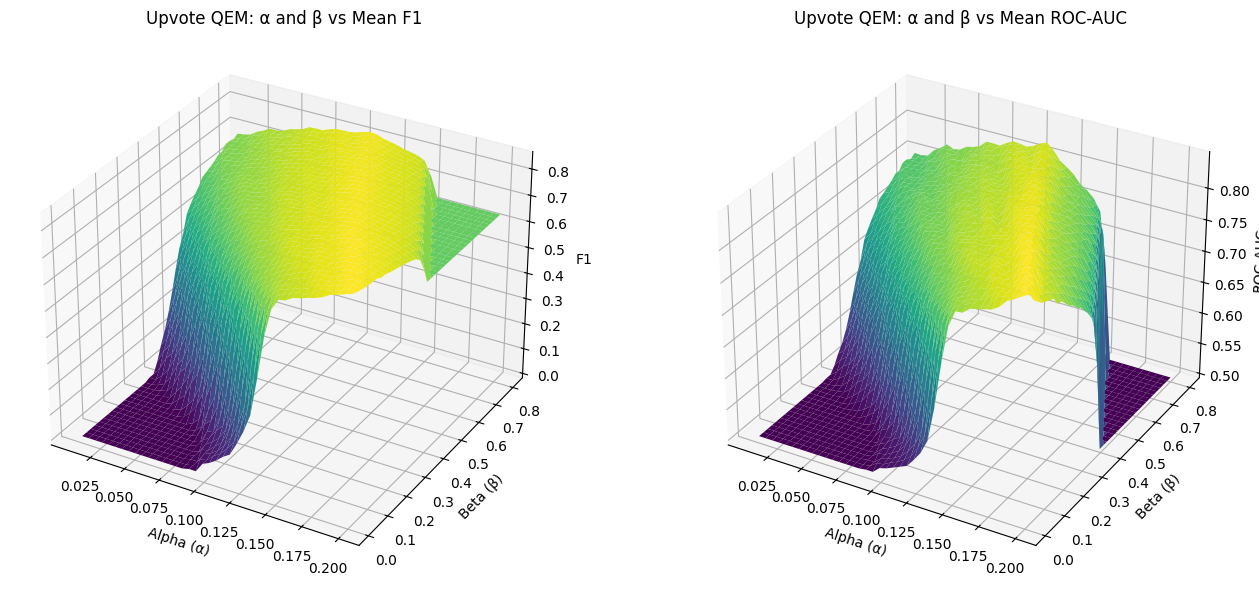

In [ ]:
f1s, roc_aucs = [], []
for i in range(K):
    f1s.append([[fold_results[i]['upvote qem']['scores'][(a, b)]['f1'] for b in betas] for a in alphas])
    roc_aucs.append([[fold_results[i]['upvote qem']['scores'][(a, b)]['roc_auc'] for b in betas] for a in alphas])

X, Y = np.meshgrid(alphas, betas)

f1s, roc_aucs = np.array(f1s), np.array(roc_aucs)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})
surface_graph(X, Y, f1s, "Alpha (\u03b1)", "Beta (\u03b2)", "F1", "Upvote QEM: \u03b1 and \u03b2 vs Mean F1", axes[0], avg=True)
surface_graph(X, Y, roc_aucs, "Alpha (\u03b1)", "Beta (\u03b2)", "ROC-AUC", "Upvote QEM: \u03b1 and \u03b2 vs Mean ROC-AUC", axes[1], avg=True)
fig.tight_layout()
fig.savefig(f'{PLOTS_DIR}upvote_qem_tuning.png')

In [ ]:
mean_f1s = np.mean(f1s, axis=0)
best_alpha, best_beta = np.unravel_index(np.argmax(mean_f1s, axis=None), mean_f1s.shape)
best_configs['upvote qem'] = (alphas[best_alpha], betas[best_beta])

### QuAD Semantics

In [ ]:
def update_upvote_quad(qbaf, ab, t_json):
    t_min, t_max = get_upvote_range(t_json)
    qbaf.update_tau(lambda n: upvote_tau(n, t_min, t_max, alpha=ab[0], beta=ab[1]))
    qbaf.update_semantics(quad_semantics)

In [ ]:
run_cross_validation('upvote quad', ab_pairs, update_upvote_quad)

Fold 1


100%|██████████| 1600/1600 [04:33<00:00,  5.85it/s]


Best config: (0.01, 0.37461538461538463), with ROC-AUC = 0.8418594563331405 and F1 = 0.8482632541133455
Fold 2


100%|██████████| 1600/1600 [05:24<00:00,  4.94it/s]


Best config: (0.01, 0.3341025641025641), with ROC-AUC = 0.833805929997528 and F1 = 0.8185654008438819
Fold 3


100%|██████████| 1600/1600 [04:51<00:00,  5.50it/s]


Best config: (0.01, 0.37461538461538463), with ROC-AUC = 0.8206749215207534 and F1 = 0.8146718146718147
Fold 4


100%|██████████| 1600/1600 [04:55<00:00,  5.42it/s]


Best config: (0.01, 0.37461538461538463), with ROC-AUC = 0.8319527312749811 and F1 = 0.8249027237354085
Fold 5


100%|██████████| 1600/1600 [05:03<00:00,  5.28it/s]

Best config: (0.01, 0.37461538461538463), with ROC-AUC = 0.8141483516483516 and F1 = 0.8085106382978723


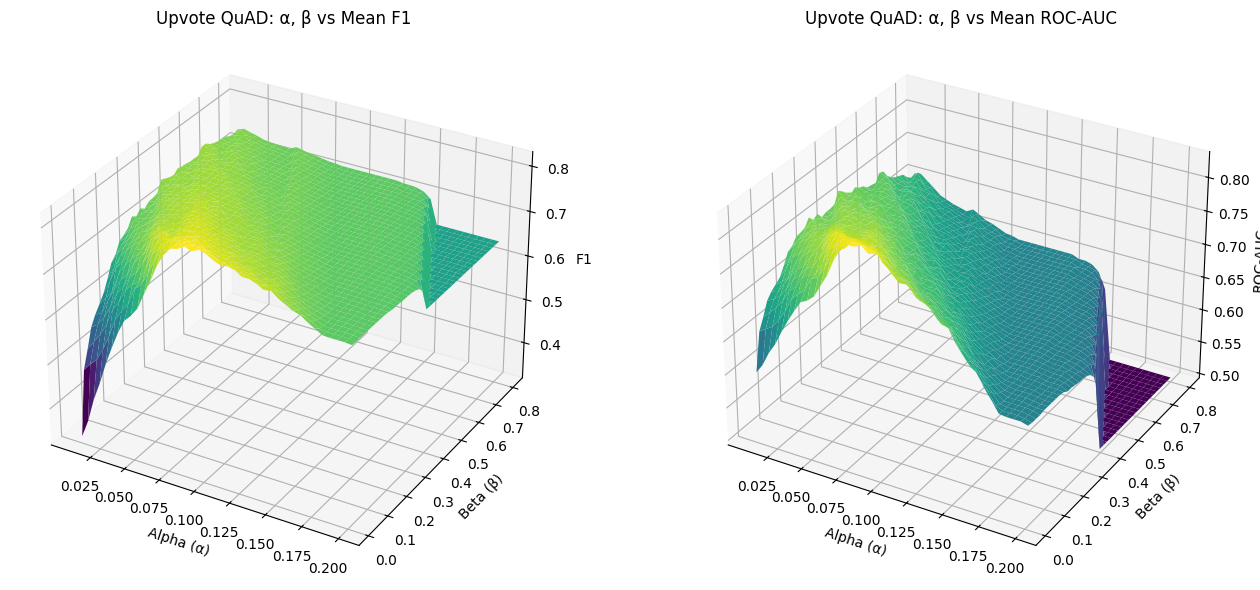

In [ ]:
f1s, roc_aucs = [], []
for i in range(K):
    f1s.append([[fold_results[i]['upvote quad']['scores'][(a, b)]['f1'] for b in betas] for a in alphas])
    roc_aucs.append([[fold_results[i]['upvote quad']['scores'][(a, b)]['roc_auc'] for b in betas] for a in alphas])

X, Y = np.meshgrid(alphas, betas)

f1s, roc_aucs = np.array(f1s), np.array(roc_aucs)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})
surface_graph(X, Y, f1s, "Alpha (\u03b1)", "Beta (\u03b2)", "F1", "Upvote QuAD: \u03b1, \u03b2 vs Mean F1", axes[0], avg=True)
surface_graph(X, Y, roc_aucs, "Alpha (\u03b1)", "Beta (\u03b2)", "ROC-AUC", "Upvote QuAD: \u03b1, \u03b2 vs Mean ROC-AUC", axes[1], avg=True)
fig.tight_layout()
fig.savefig(f'{PLOTS_DIR}upvote_quad_tuning.png')

In [ ]:
mean_f1s = np.mean(f1s, axis=0)
best_alpha, best_beta = np.unravel_index(np.argmax(mean_f1s, axis=None), mean_f1s.shape)
best_configs['upvote quad'] = (alphas[best_alpha], betas[best_beta])

### REB Semantics

In [ ]:
def update_upvote_reb(qbaf, ab, t_json):
    t_min, t_max = get_upvote_range(t_json)
    qbaf.update_tau(lambda n: upvote_tau(n, t_min, t_max, alpha=ab[0], beta=ab[1]))
    qbaf.update_semantics(reb_semantics)

In [ ]:
run_cross_validation('upvote reb', ab_pairs, update_upvote_reb)

Fold 1


100%|██████████| 1600/1600 [08:30<00:00,  3.14it/s]


Best config: (0.01, 0.35435897435897434), with ROC-AUC = 0.8619722382880277 and F1 = 0.8767123287671232
Fold 2


100%|██████████| 1600/1600 [08:55<00:00,  2.99it/s]


Best config: (0.01, 0.35435897435897434), with ROC-AUC = 0.8501577745786618 and F1 = 0.8482632541133455
Fold 3


100%|██████████| 1600/1600 [08:37<00:00,  3.09it/s]


Best config: (0.01, 0.35435897435897434), with ROC-AUC = 0.8480263922799675 and F1 = 0.8472727272727273
Fold 4


100%|██████████| 1600/1600 [08:50<00:00,  3.02it/s]


Best config: (0.01, 0.35435897435897434), with ROC-AUC = 0.8540665006082373 and F1 = 0.8524590163934426
Fold 5


100%|██████████| 1600/1600 [08:42<00:00,  3.06it/s]

Best config: (0.01, 0.35435897435897434), with ROC-AUC = 0.839517061885483 and F1 = 0.8411552346570397


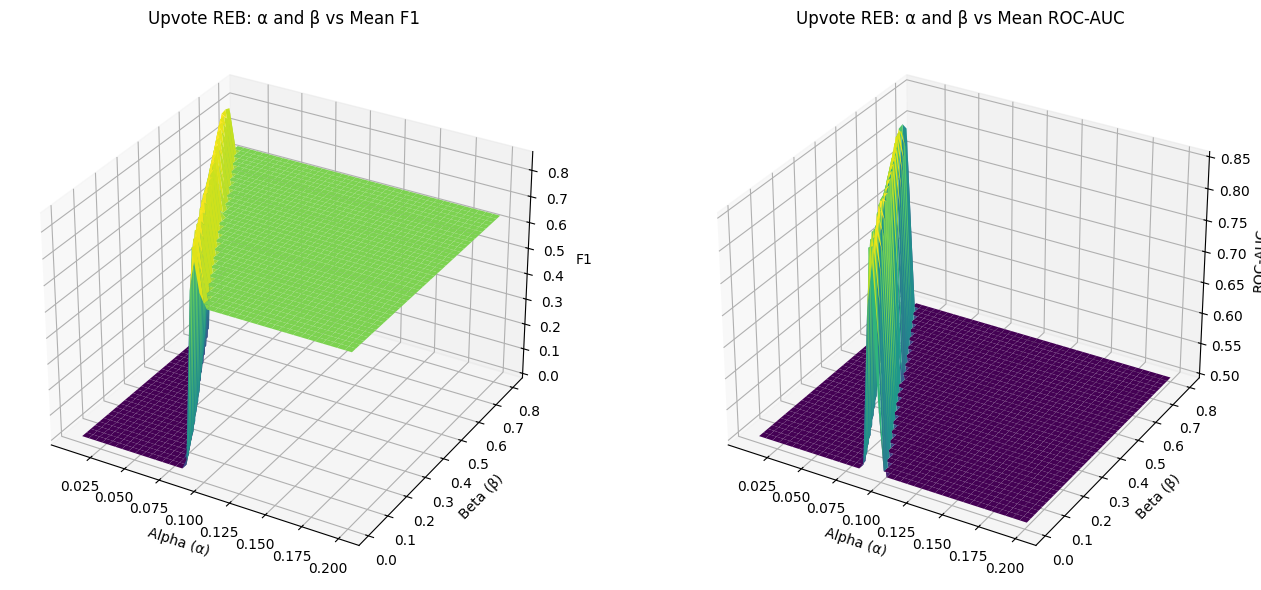

In [ ]:
f1s, roc_aucs = [], []
for i in range(K):
    f1s.append([[fold_results[i]['upvote reb']['scores'][(a, b)]['f1'] for b in betas] for a in alphas])
    roc_aucs.append([[fold_results[i]['upvote reb']['scores'][(a, b)]['roc_auc'] for b in betas] for a in alphas])

X, Y = np.meshgrid(alphas, betas)

f1s, roc_aucs = np.array(f1s), np.array(roc_aucs)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})
surface_graph(X, Y, f1s, "Alpha (\u03b1)", "Beta (\u03b2)", "F1", "Upvote REB: \u03b1 and \u03b2 vs Mean F1", axes[0], avg=True)
surface_graph(X, Y, roc_aucs, "Alpha (\u03b1)", "Beta (\u03b2)", "ROC-AUC", "Upvote REB: \u03b1 and \u03b2 vs Mean ROC-AUC", axes[1], avg=True)
fig.tight_layout()
fig.savefig(f'{PLOTS_DIR}upvote_reb_tuning.png')

In [ ]:
mean_f1s = np.mean(f1s, axis=0)
best_alpha, best_beta = np.unravel_index(np.argmax(mean_f1s, axis=None), mean_f1s.shape)
best_configs['upvote reb'] = (alphas[best_alpha], betas[best_beta])

## Overall Test Results

In [ ]:
print(train_data.shape, test_data.shape)

(658, 5) (165, 5)


In [ ]:
classifers = [
    ("fixed df-quad", update_fixed_df), ("fixed qem", update_fixed_qem),
    ("fixed quad", update_fixed_quad), ("fixed reb", update_fixed_quad),
    ("upvote df-quad", update_upvote_df), ("upvote qem", update_upvote_qem),
    ("upvote quad", update_upvote_quad), ("upvote reb", update_upvote_reb),
]

In [ ]:
test_results = {}

# Calculate the metrics for each classier on the test data
for c, cf in classifers:
    p = best_configs[c]
    print(f"Testing {c} with best config {p}")
    for qbaf, t_json in zip(test_qbafs, test_jsons):
        cf(qbaf, p, t_json=t_json)
    pred_verdicts = test_qbafs.apply(lambda qbaf: qbaf.get_stance(return_score=True))
    pred_verdicts = pd.DataFrame(pred_verdicts.tolist(), index=test_qbafs.index, columns=['stance', 'score'])
    test_results[c] = pred_verdicts


Testing fixed df-quad with best config 0.23767676767676768


Testing fixed qem with best config 0.41585858585858587
Testing fixed quad with best config 0.16343434343434343
Testing fixed reb with best config 0.18818181818181817
Testing upvote df-quad with best config (0.01, 0.49615384615384617)
Testing upvote qem with best config (0.04897435897435898, 0.718974358974359)
Testing upvote quad with best config (0.01, 0.37461538461538463)
Testing upvote reb with best config (0.01, 0.35435897435897434)


### Plots

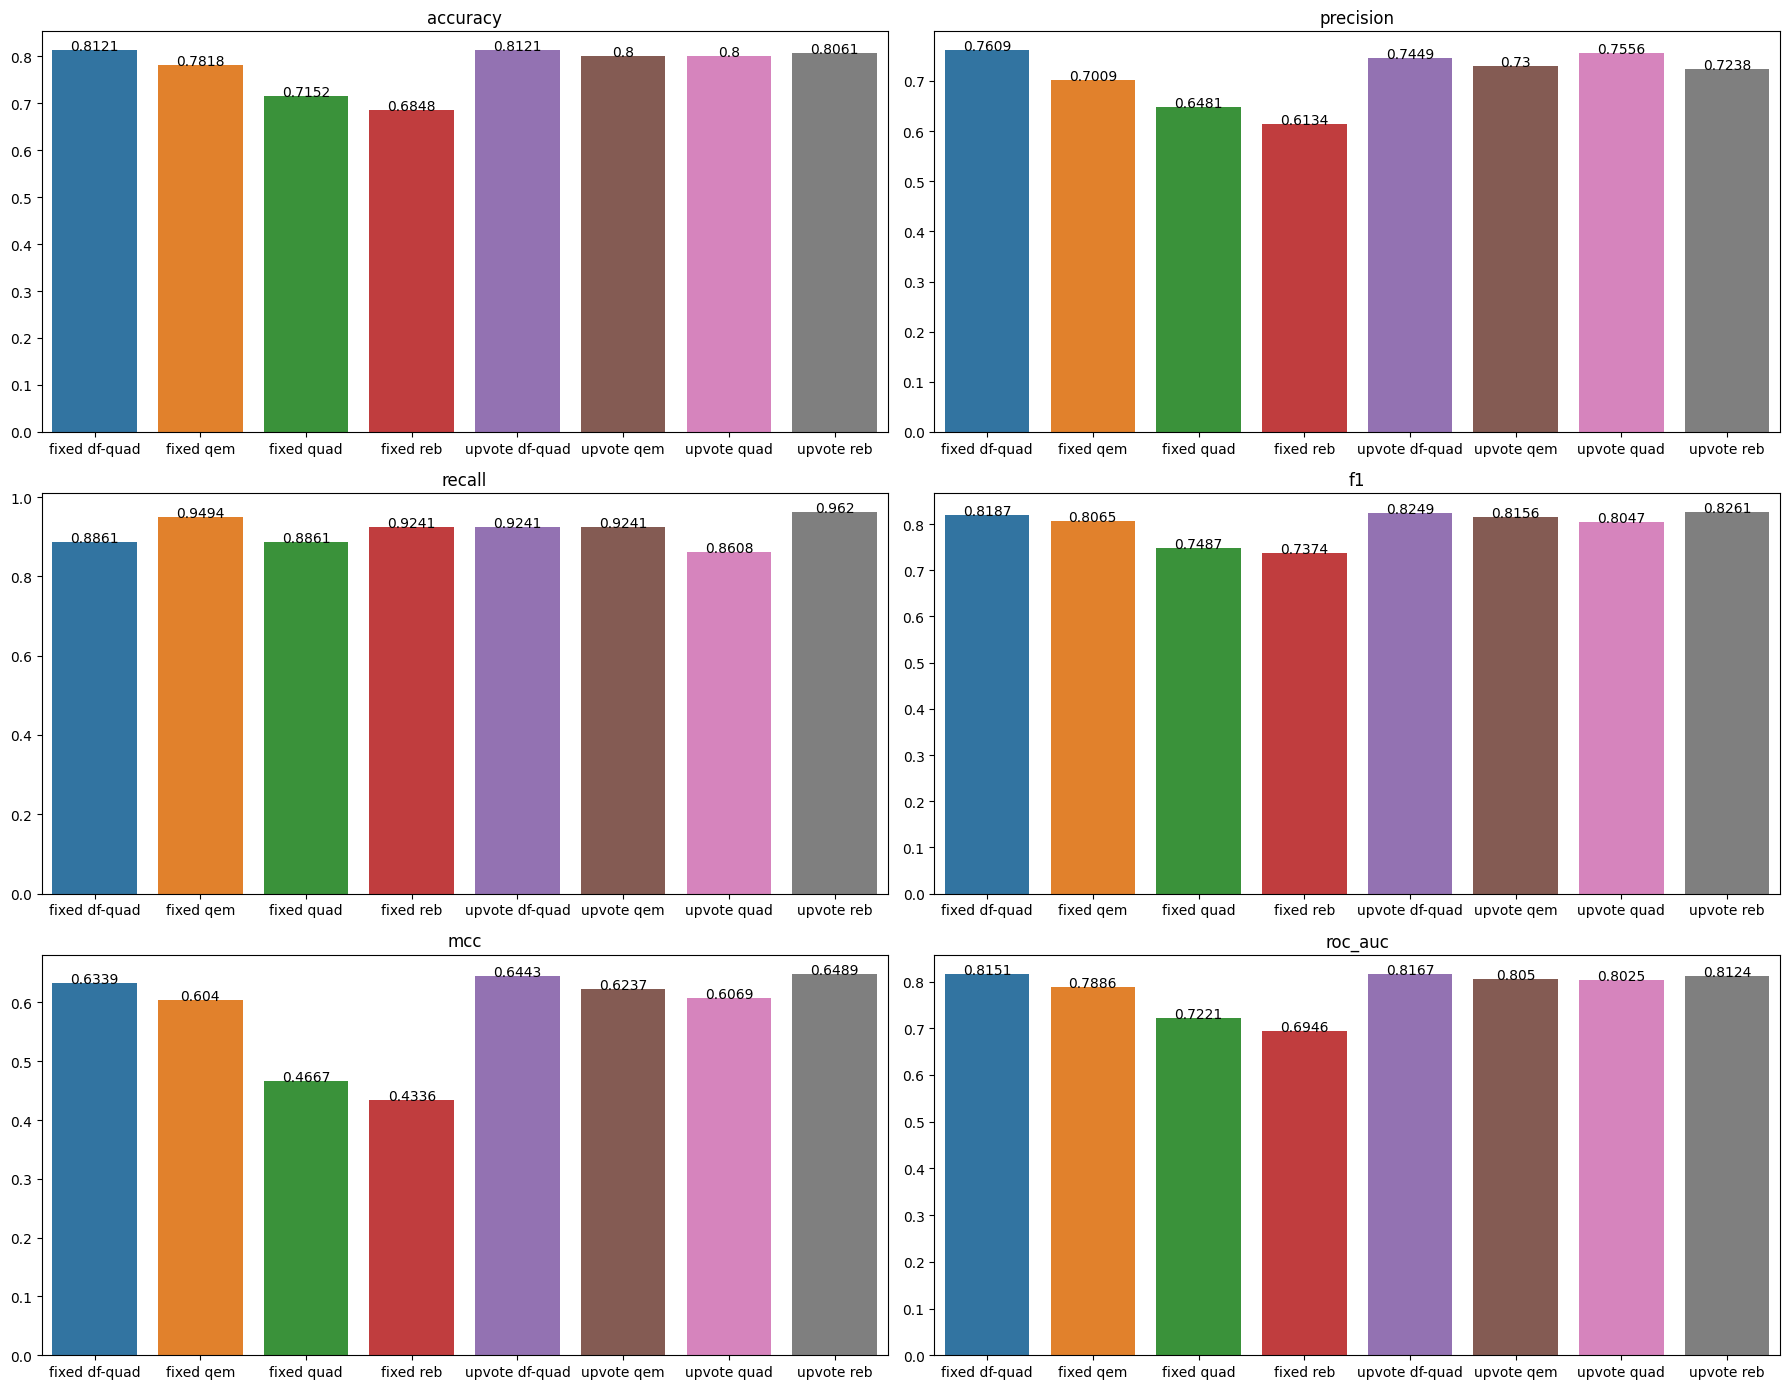

In [ ]:
# Compare the performance of the classifiers on the test data

classifier_metrics = {'accuracy': {}, 'precision': {}, 'recall': {}, 'f1': {}, 'mcc': {}, 'roc_auc': {}}
for c, _ in classifers:
    metrics = classification_metrics(test_labels, test_results[c]['stance'])
    for m in classifier_metrics.keys():
        classifier_metrics[m][c] = metrics[m]

fig, axes = plt.subplots(3, 2, figsize=(18, 14))
for i, m in enumerate(classifier_metrics.keys()):
    bar_chart(classifier_metrics[m], m, axes[i//2, i%2])
    # Add values to bars
    for j, v in enumerate(classifier_metrics[m].values()):
        axes[i//2, i%2].text(j, v, float_str(v, 4), color='black', ha='center')
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}classifier_metrics.png")

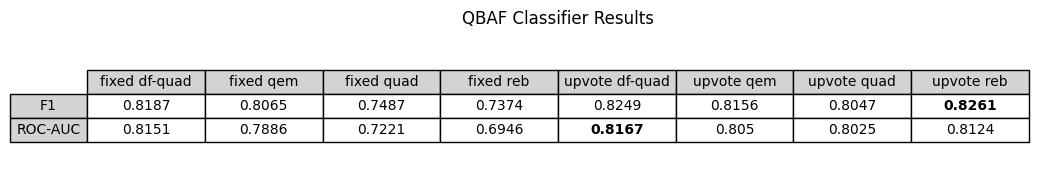

In [ ]:
# Display table of f1 and roc_auc scores

f1_scores = {c: classifier_metrics['f1'][c] for c in classifier_metrics['f1'].keys()}
roc_auc_scores = {c: classifier_metrics['roc_auc'][c] for c in classifier_metrics['roc_auc'].keys()}

scores_df = pd.DataFrame([f1_scores, roc_auc_scores], index=['F1', 'ROC-AUC'])
rounded_scores_df = scores_df.map(lambda x: float_str(x, 4))

max_f1 = np.argmax(list(f1_scores.values()))
max_roc_auc = np.argmax(list(roc_auc_scores.values()))

colColours = ['lightgrey' for i in range(len(scores_df.columns))]
rowColours = ['lightgrey' for i in range(len(scores_df.index))]

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.axis('off')
table = ax.table(
    cellText=rounded_scores_df.values, colLabels=scores_df.columns, rowLabels=scores_df.index,
    loc='center', cellLoc='center', colLoc='center', rowLoc='center',
    colColours=colColours, rowColours=rowColours
)
table.auto_set_font_size(False)
# table.set_fontsize(14)
table.scale(1.5, 1.5)
# Make highest scores bold
font_props = FontProperties(weight='bold') # , size=14
table[(1, max_f1)].set_text_props(font_properties=font_props)
table[(2, max_roc_auc)].set_text_props(font_properties=font_props)
plt.title('QBAF Classifier Results')
fig.tight_layout()
fig.savefig(f"{PLOTS_DIR}classifier_scores_table.png")

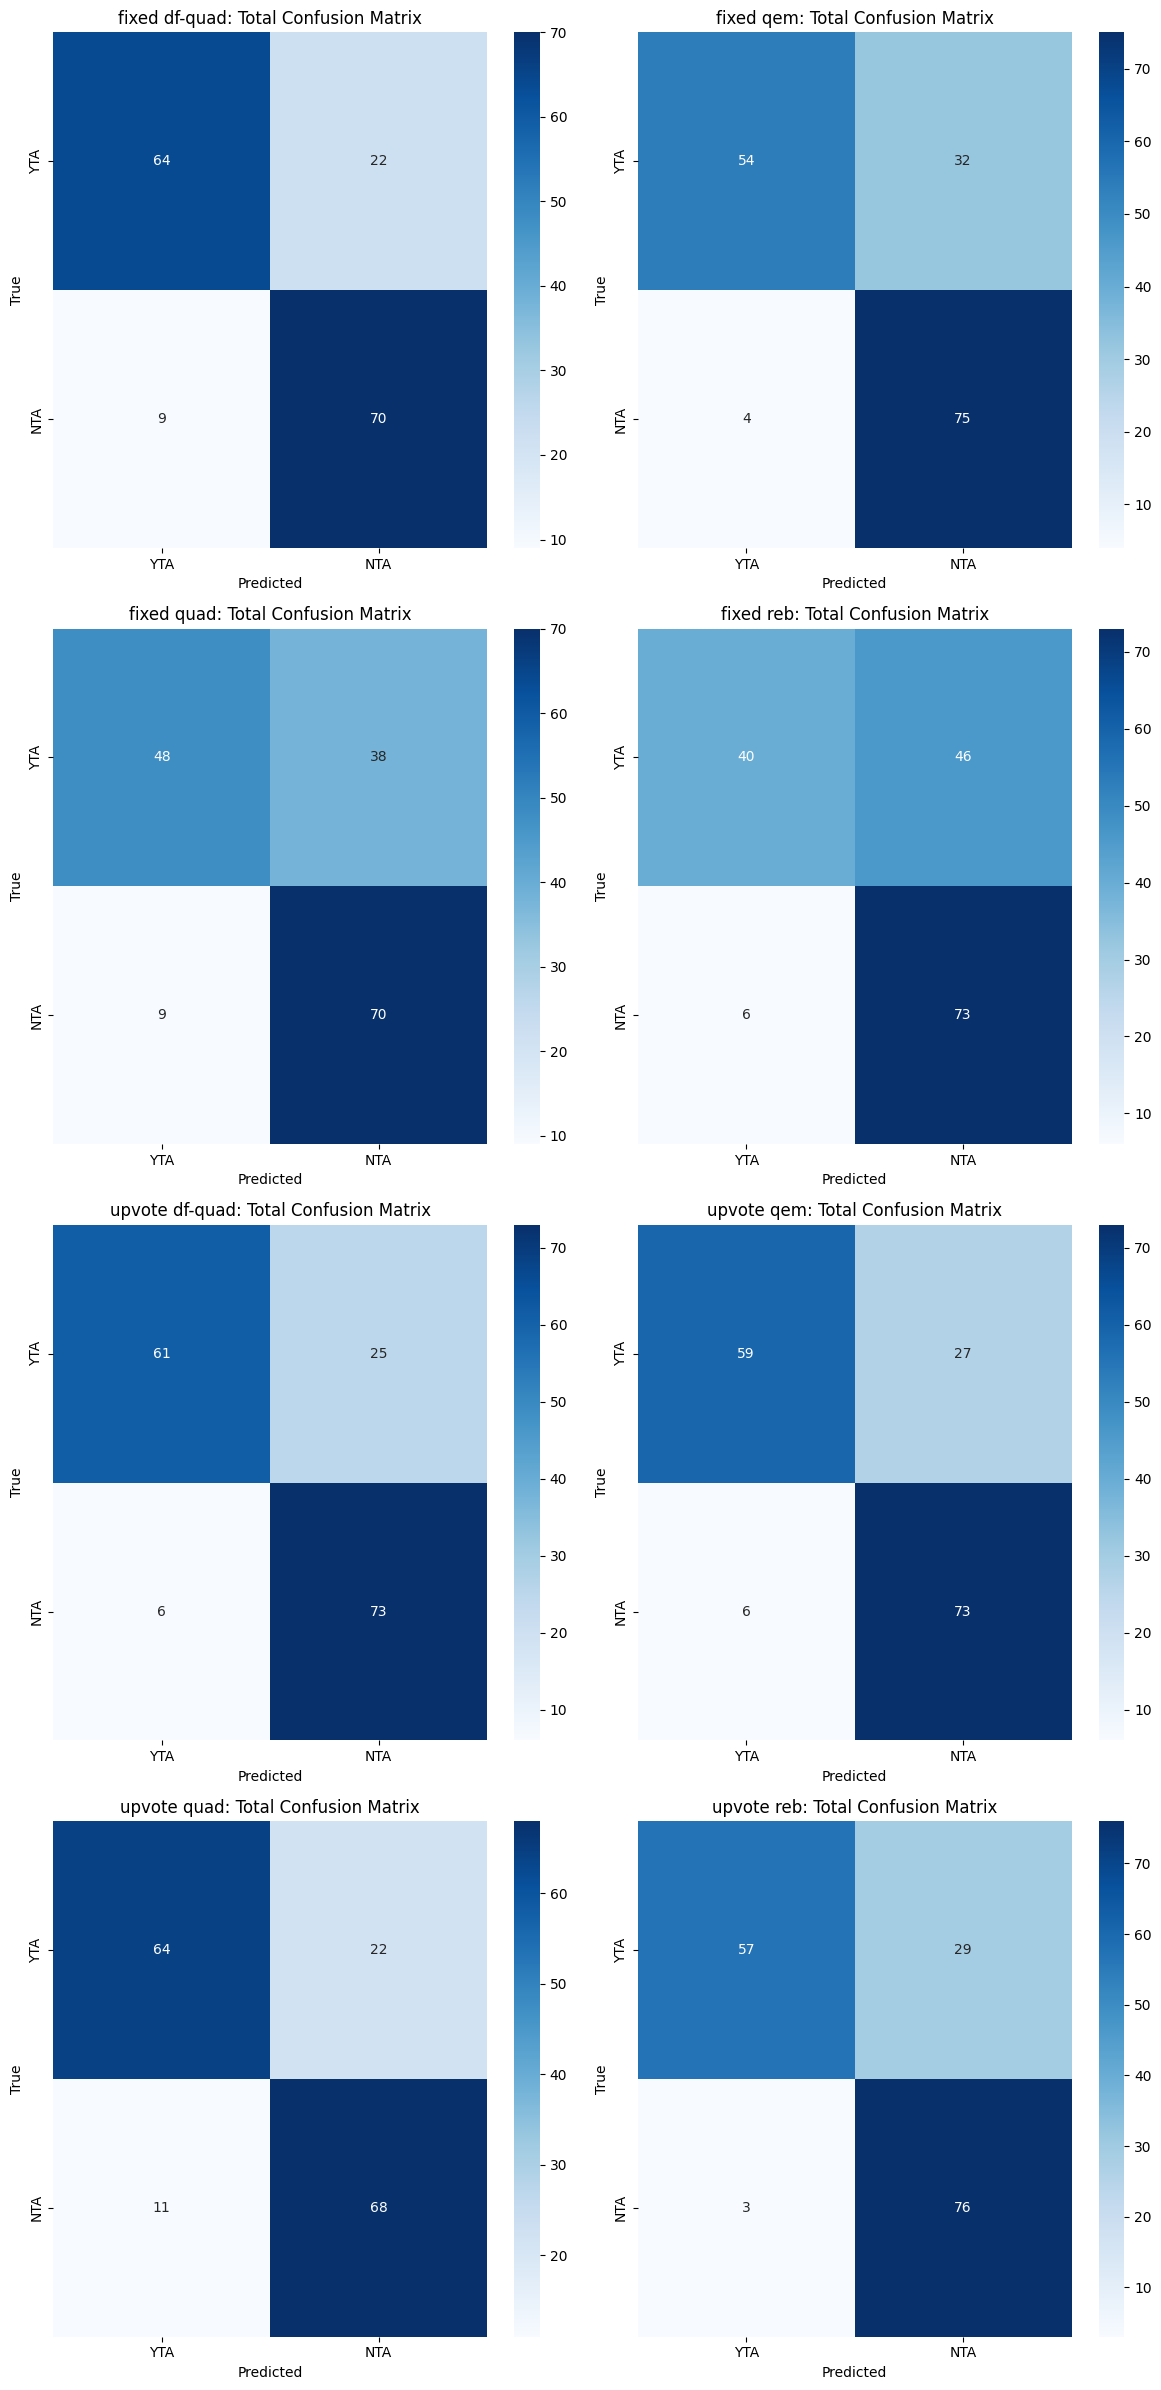

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
# Compare confusion matrices
fig, axes = plt.subplots(4, 2, figsize=(12, 24))
colours = matplotlib.colormaps['tab10'].colors[:len(classifers)]

for j, (c, _) in enumerate(classifers):
    display_confusion_matrix(test_labels, test_results[c]['stance'], 'YTA', 'NTA', f'{c}: Total Confusion Matrix', ax=axes[j//2, j%2])

fig.tight_layout()
fig.savefig(f'{PLOTS_DIR}total_confusion_matrices.png')

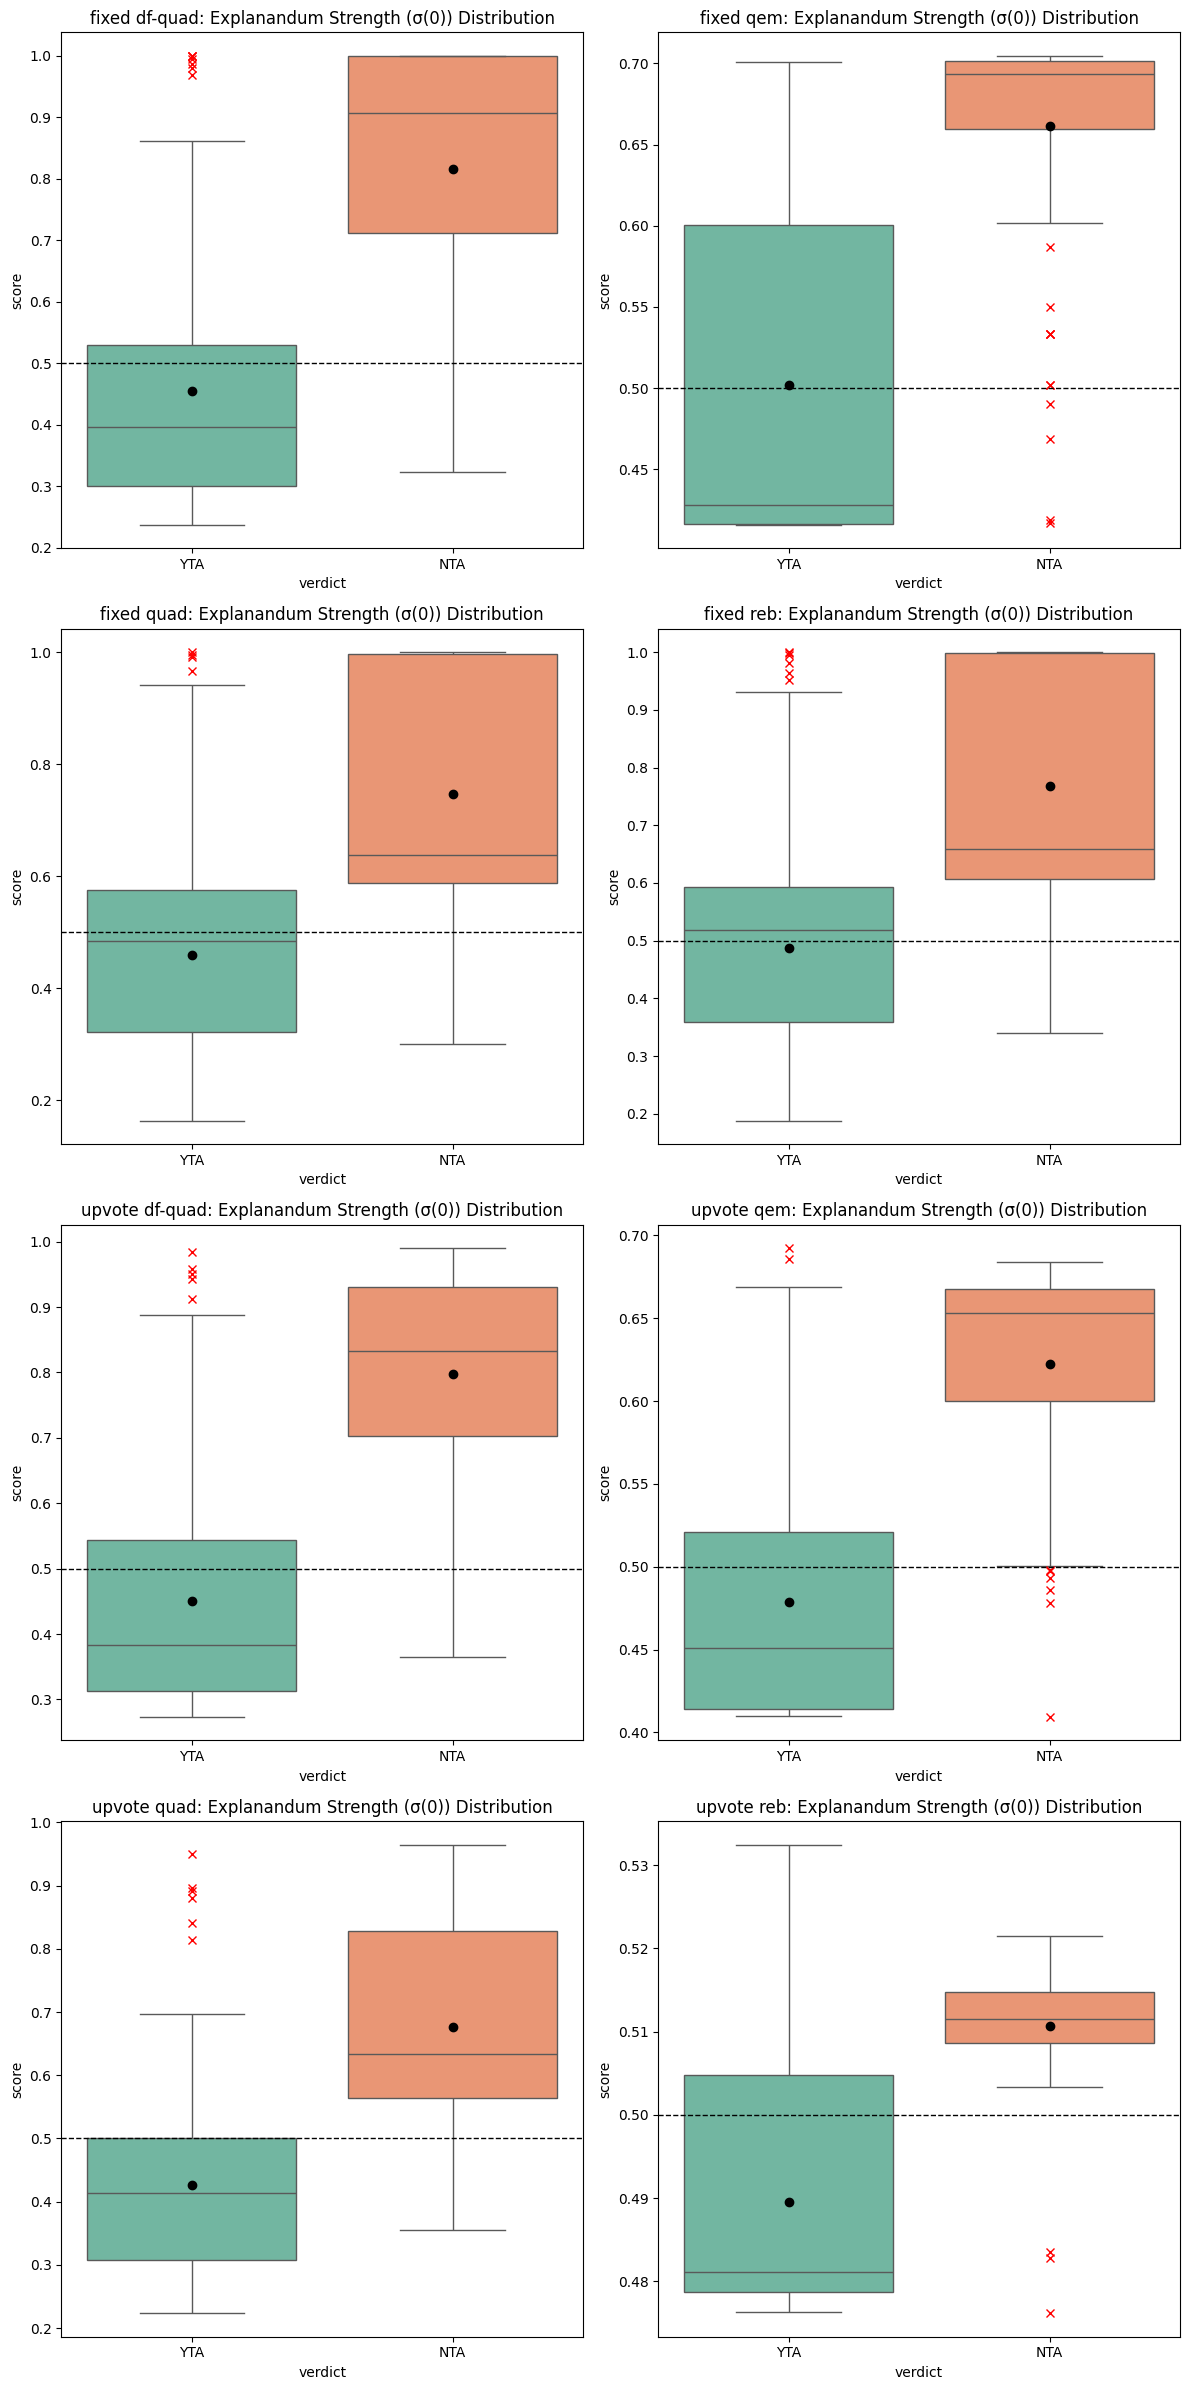

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [ ]:
# Compare the score distributions

fig, axes = plt.subplots(4, 2, figsize=(12, 24))

for j, (c, _) in enumerate(classifers):
    boxplot_scores(test_labels.apply(lambda v: 'NTA' if v == 1 else 'YTA'), test_results[c]['score'], title=f'{c}: Explanandum Strength (\u03c3(0)) Distribution', ax=axes[j//2, j%2])

fig.tight_layout()
fig.savefig(f'{PLOTS_DIR}total_score_distributions.png')

### Missclassified Reddit Posts

In [ ]:
# Of all the misclassified examples, which ones are common across classifiers?

misclassified = {c: find_misclassified(test_labels, test_results[c]['stance'], data=test_data) for c, _ in classifers}

all_misclassified = list(set.union(*[set(m.index) for m in misclassified.values()]))

misclassified_by = {t: [1 if t in misclassified[c].index else 0 for c in misclassified.keys()] for t in all_misclassified}


misclassified_df = pd.DataFrame.from_dict(misclassified_by, orient='index', columns=[c for c, _ in classifers])
# Sort by number of classifiers that misclassified
misclassified_df = misclassified_df.sort_values(by=list(misclassified_df.columns), ascending=False)
print(misclassified_df.sum())

fixed df-quad     31
fixed qem         36
fixed quad        47
fixed reb         52
upvote df-quad    31
upvote qem        33
upvote quad       33
upvote reb        32
dtype: int64


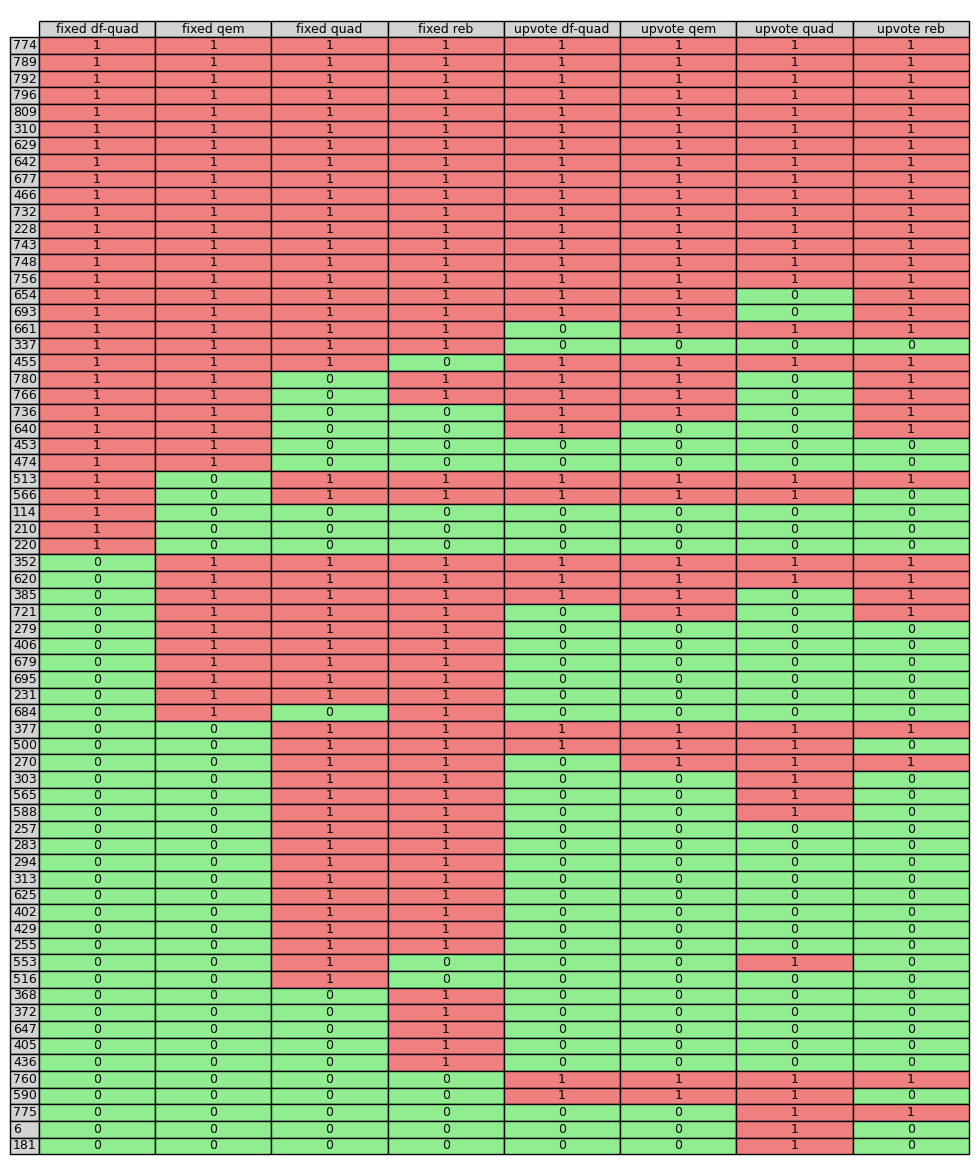

In [ ]:
# Display table of misclassified examples
fig, ax = plt.subplots(1, 1, figsize=(12, 15))
col_colours = ['lightgrey'] * len(misclassified_df.columns)
row_colours = ['lightgrey'] * len(misclassified_df.index)
# cell_colours = ['lightred' if misclassified_df.iloc[i, j] == 1 else 'lightgreen' for i in range(len(misclassified_df.index)) for j in range(len(misclassified_df.columns))]
cell_colours = misclassified_df.map(lambda x: 'lightcoral' if x == 1 else 'lightgreen').values
ax.axis('off')
ax.table(
    cellText=misclassified_df.values, colLabels=misclassified_df.columns, rowLabels=misclassified_df.index,
    loc='center', cellLoc='center', colColours=col_colours, cellColours=cell_colours, rowColours=row_colours
)
fig.savefig(f'{PLOTS_DIR}misclassified_table.png')

In [ ]:
mis_verdicts = reddit_posts.iloc[misclassified_df.index]
print(mis_verdicts['verdict'].value_counts())

verdict
YTA    50
NTA    17
Name: count, dtype: int64
